<a href="https://colab.research.google.com/github/StillWork/ds-lab/blob/master/gg_z_%E1%84%92%E1%85%A2%E1%86%BC%E1%84%83%E1%85%A9%E1%86%BC%E1%84%83%E1%85%A6%E1%84%8B%E1%85%B5%E1%84%90%E1%85%A5%E1%84%87%E1%85%AE%E1%86%AB%E1%84%89%E1%85%A5%E1%86%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !pip install coremltools

    100% |████████████████████████████████| 3.1MB 3.3MB/s ta 0:00:011
You are using pip version 18.0, however version 19.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
# import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## 여섯개의 레이블을 사용한다.
- Downstairs, Jogging, Sitting, Standing, Upstairs, Walking
### 아래 변수를 정의한다.
- TIME_PERIODS stores the length of the time segment. 
- STEP_DISTANCE determines the amount of overlap between two consecutive time segments


In [0]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40

keras version  2.2.2


In [0]:
import os, os.path, shutil
if not os.path.exists("./data"):
    os.makedirs("./data")
!curl http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz \
 -o ./data/WISDM_ar_latest.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.8M  100 10.8M    0     0   938k      0  0:00:11  0:00:11 --:--:-- 1732k56k    0     0   242k      0  0:00:45  0:00:03  0:00:42  242k


In [0]:
fname = './data/WISDM_ar_latest.tar.gz'

import tarfile
if (fname.endswith("tar.gz")):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall('./data')
    tar.close()
elif (fname.endswith("tar")):
    tar = tarfile.open(fname, "r:")
    tar.extractall('./data')
    tar.close()

In [0]:
!ls

WISDM_ar_latest.tar.gz
data
g-01-파이선기초.ipynb
g-02-그래프.ipynb
g-03-numpy.ipynb
g-04-pandas.ipynb
g-05-데이터탐색.ipynb
g-06-데이터전처리.ipynb
g-07-데이터변환.ipynb
g-08-클러스터링.ipynb
g-09-주성분분석-tSNE-유방암.ipynb
g-10-선형회귀.ipynb
g-11-회귀직선.ipynb
g-12-이진분류-선형.ipynb
g-13-이진분류-SVM-kNN.ipynb
g-14-결정트리-붓꽃.ipynb
g-15-결정트리-타이타닉.ipynb
g-16-랜덤포레스트-그리드탐색.ipynb
g-17-자전거대여예측-colab.ipynb
g-17-자전거대여예측.ipynb
g-18-로지스틱회귀-유방암.ipynb
g-19-베이즈-텍스트분석.ipynb
g-20-ROC-샘플.ipynb
g-21-분류성능비교-ROC.ipynb
gg05-(원본)주택가격탐색.ipynb
gg05-통계적분석-주택가격예측.ipynb
h_activity_classification_ipynb의_사본.ipynb
타이타닉.ipynb


In [0]:
!ls data/WISDM_ar_v1.1/

WISDM_ar_v1.1_raw.txt          WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1_raw_about.txt    readme.txt
WISDM_ar_v1.1_trans_about.txt


In [0]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
# def show_basic_dataframe_info(dataframe):

#     # Shape and how many rows and columns
#     print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
#     print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('./data/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

In [0]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2


In [0]:
df.shape

(1098203, 6)

In [0]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

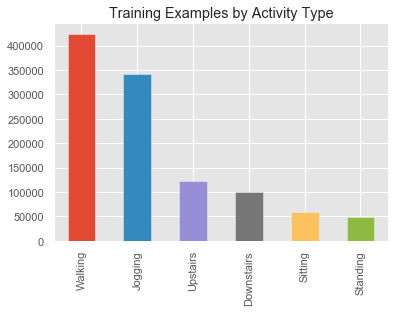

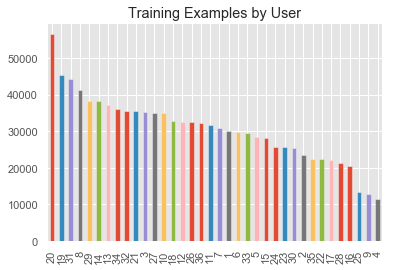

In [0]:
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                              title='Training Examples by Activity Type')
plt.show()
# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                             title='Training Examples by User')
plt.show()

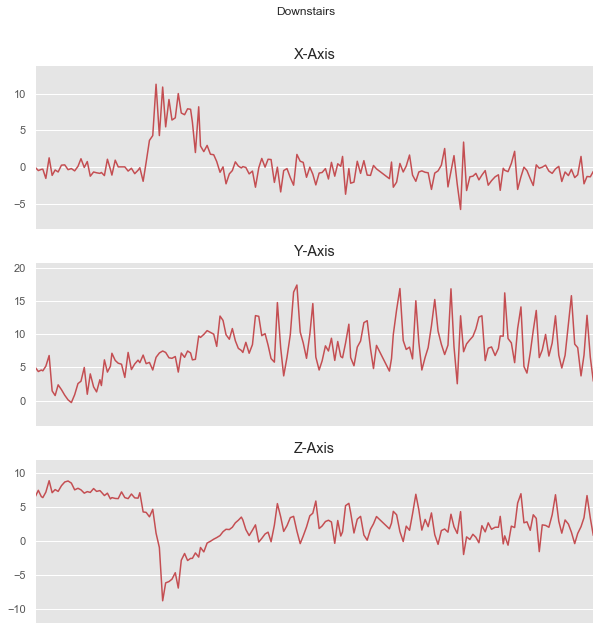

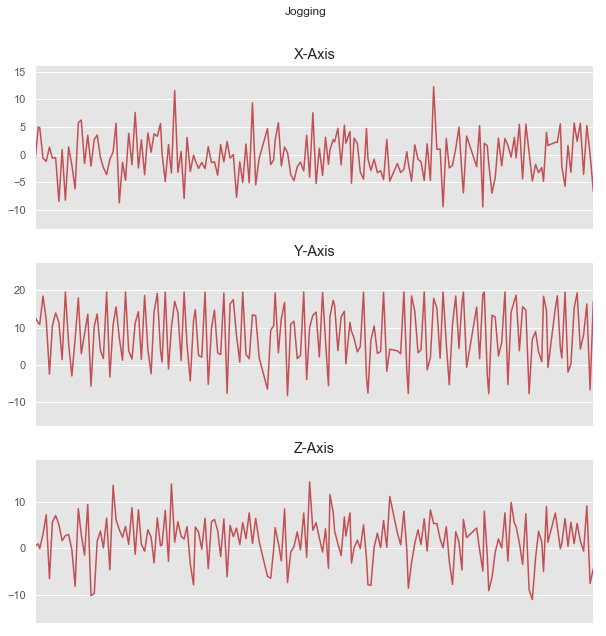

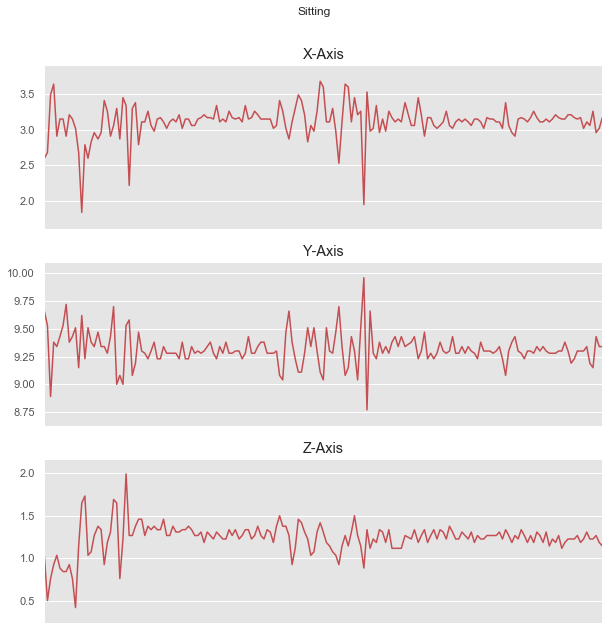

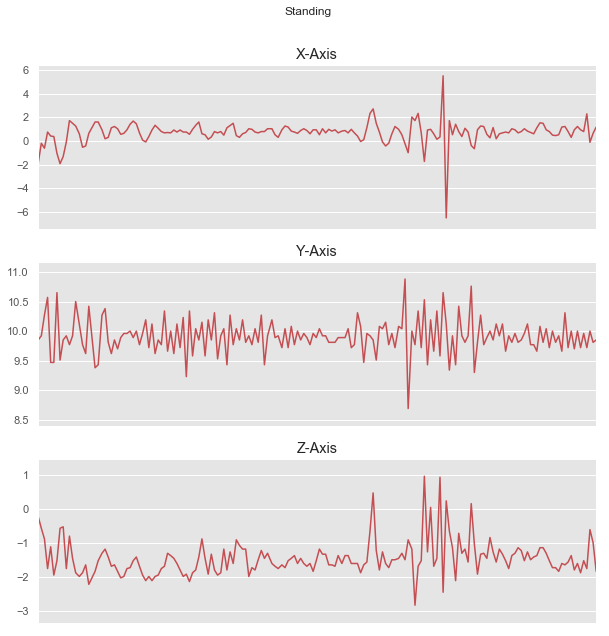

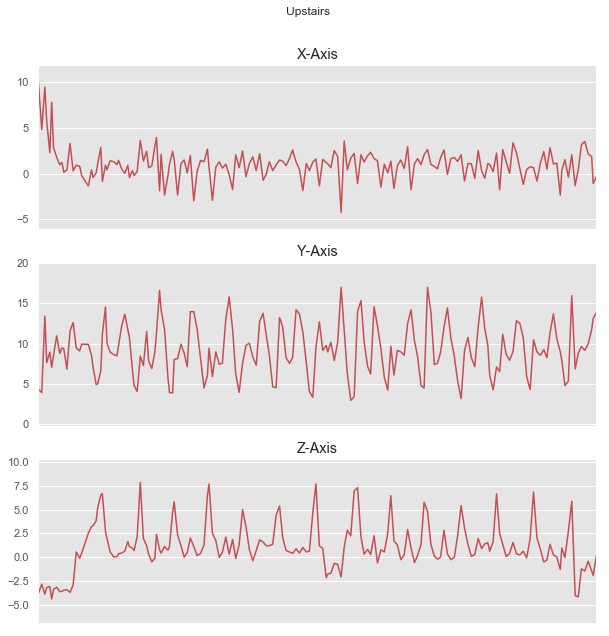

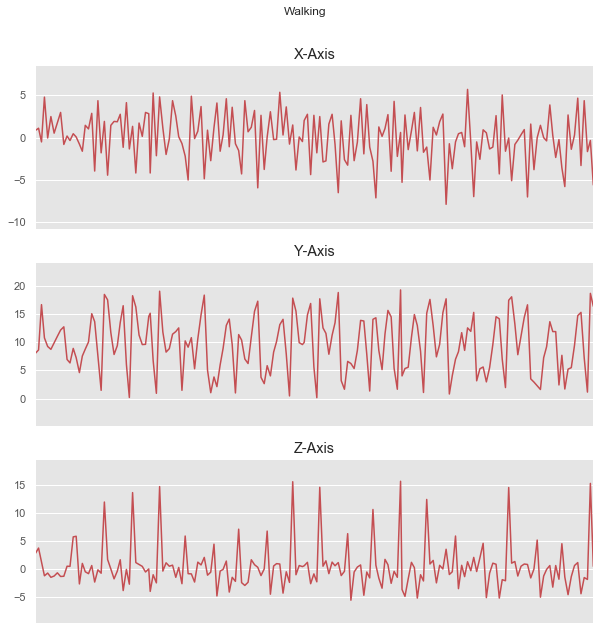

In [0]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [0]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

## Split Data into Training and Test Set

- split by human base
- train with ID 1~28
- test with ID 29~



In [0]:
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

In [0]:
df_test[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1


In [0]:
# normalize
# SHOULD use the same normalization for 'test' data !

# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()
# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [0]:
df_test[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.0,0.6,0.0,1
1,33,Jogging,49106062271000,0.3,0.6,0.1,1
2,33,Jogging,49106112167000,0.2,0.6,-0.0,1


### DNN입력 데이터 준비

- 배치 크기를 4초 (80샘플)로 지정
- 입력 데이터를 3개의 축 성분으로 나눈다
- 레이블 정보를 준비한다

In [0]:
def create_segments_and_labels(df, time_steps, step, label_name):

    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

x_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [0]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [0]:
print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape: ', y_test.shape)

x_test shape:  (6584, 80, 3)
6584 test samples
y_test shape:  (6584,)


In [0]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [0]:
# 2차원 데이터를 1차원으로 만들어서 케라스에 입력
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
x_test = x_test.reshape(x_test.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)
print('x_test shape:', x_test.shape)

x_train shape: (20868, 240)
input_shape: 240
x_test shape: (6584, 240)


In [0]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

In [0]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
y_test_hot = np_utils.to_categorical(y_test, num_classes)

print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


In [0]:
y_train_hot[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [0]:
y_test_hot[:3]

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [0]:
model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
_________________________________________________________________
None


## 동작 환경 설정
- 조기 종료 (2회 동안 개선되지 않으면 종료)
- 배키 크기 400
- 이포크 50
- 훈련데이터: 검증 데이터 = 8:2


In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 30

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Train on 16694 samples, validate on 4174 samples
Epoch 1/30
16694/16694 [==============================] - 6s 353us/step - loss: 1.0861 - acc: 0.6383 - val_loss: 0.7283 - val_acc: 0.8026
Epoch 2/30
16694/16694 [==============================] - 6s 350us/step - loss: 0.5974 - acc: 0.7865 - val_loss: 0.6711 - val_acc: 0.7961
Epoch 3/30
16694/16694 [==============================] - 6s 345us/step - loss: 0.5258 - acc: 0.8067 - val_loss: 0.6477 - val_acc: 0.8071
Epoch 4/30
16694/16694 [==============================] - 6s 331us/step - loss: 0.4913 - acc: 0.8211 - val_loss: 0.6406 - val_acc: 0.8136
Epoch 5/30
16694/16694 [==============================] - 6s 367us/step - loss: 0.4650 - acc: 0.8322 - val_loss: 0.6658 - val_acc: 0.7937
Epoch 6/30
16694/16694 [==============================] - 6s 341us/step - loss: 0.4456 - acc: 0.8388 - val_loss: 0.6835 - val_acc: 0.8148
Epoch 7/30
16694/16694 [==============================] - 6s 370us/step - loss: 0.4355 - acc: 0.8429 - val_loss: 0.7162 - v

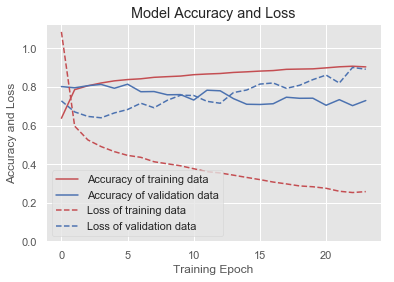

             precision    recall  f1-score   support

        0.0       0.56      0.59      0.58      1864
        1.0       0.96      0.99      0.97      6567
        2.0       0.99      0.99      0.99      1050
        3.0       0.99      0.99      0.99       833
        4.0       0.71      0.53      0.60      2342
        5.0       0.87      0.91      0.89      8212

avg / total       0.87      0.87      0.87     20868



In [0]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

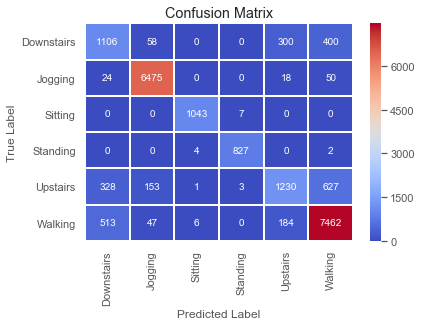

In [0]:
show_confusion_matrix(y_train, max_y_pred_train)

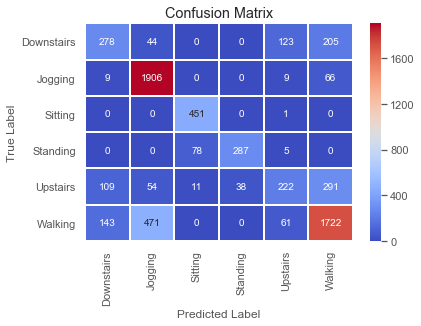

             precision    recall  f1-score   support

        0.0       0.52      0.43      0.47       650
        1.0       0.77      0.96      0.85      1990
        2.0       0.84      1.00      0.91       452
        3.0       0.88      0.78      0.83       370
        4.0       0.53      0.31      0.39       725
        5.0       0.75      0.72      0.74      2397

avg / total       0.72      0.74      0.72      6584



In [0]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
show_confusion_matrix(y_test, max_y_pred_test)
print(classification_report(y_test, max_y_pred_test))

In [0]:
## 계단 오르기에서 오류가 많은 것을 알 수 있다.
## 맥 ios에서 동작시키기 위해서 CoreML 모듈로 전환한다

In [0]:

coreml_model = coremltools.converters.keras.convert(model_m,
                                                    input_names=['acceleration'],
                                                    output_names=['output'],
                                                    class_labels=LABELS)

print(coreml_model)
coreml_model.author = 'Nils Ackermann'
coreml_model.license = 'N/A'
coreml_model.short_description = 'Activity based recognition based on WISDM dataset'
coreml_model.output_description['output'] = 'Probability of each activity'
coreml_model.output_description['classLabel'] = 'Labels of activity'

coreml_model.save('HARClassifier.mlmodel')

0 : reshape_1_input, <keras.engine.input_layer.InputLayer object at 0x1a19845400>
1 : reshape_1, <keras.layers.core.Reshape object at 0x1021cd860>
2 : dense_1, <keras.layers.core.Dense object at 0x102157400>
3 : dense_1__activation__, <keras.layers.core.Activation object at 0x1a1991b898>
4 : dense_2, <keras.layers.core.Dense object at 0x1a19845470>
5 : dense_2__activation__, <keras.layers.core.Activation object at 0x1a1991b780>
6 : dense_3, <keras.layers.core.Dense object at 0x1a198456a0>
7 : dense_3__activation__, <keras.layers.core.Activation object at 0x1a1991be80>
8 : flatten_1, <keras.layers.core.Flatten object at 0x1a373f4a90>
9 : dense_4, <keras.layers.core.Dense object at 0x1a36f72b38>
10 : dense_4__activation__, <keras.layers.core.Activation object at 0x1a1991bd30>
input {
  name: "acceleration"
  type {
    multiArrayType {
      shape: 240
      dataType: DOUBLE
    }
  }
}
output {
  name: "output"
  type {
    dictionaryType {
      stringKeyType {
      }
    }
  }
}
outp

In [0]:
print('\nPrediction from Keras:')
test_record = x_test[1].reshape(1,input_shape)
keras_prediction = np.argmax(model_m.predict(test_record), axis=1)
print(le.inverse_transform(keras_prediction)[0])
print('\nPrediction from Coreml:')
coreml_prediction = coreml_model.predict({'acceleration': test_record.reshape(input_shape)})
print(coreml_prediction["classLabel"])


Prediction from Keras:
Jogging

Prediction from Coreml:
Jogging


/Users/hwa-jongkim/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 아이폰 ios에서 실행하는 예
https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-2-857104583d94